# Demo on how to use AMPERE derived conductances in Lompe

This demo replicates the notebook from the initial Lompe paper '04_north_america' example, where the Hardy conductance is replaced with the one by Robinson et al 2022 based on AMPERE fitted field-aligned currents: https://doi.org/10.1029/2020SW002677. Here the Lompe technique applied in a grid over North America on 5 April 2012. The data input is from *SuperMAG* (ground magnetometers), *Iridium* (space magnetometer data, provided by [AMPERE](http://ampere.jhuapl.edu/)), and *SuperDARN* (ground radar measurements of line-of-sight F-region plasma convection). This is a copy of the Solar conductance is calcualted by the method described in the Lompe paper ([Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). 

Start by loading relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import lompe
import apexpy

##### Grid
Set up analysis grid and plot to see location and orientation on map (over North America).

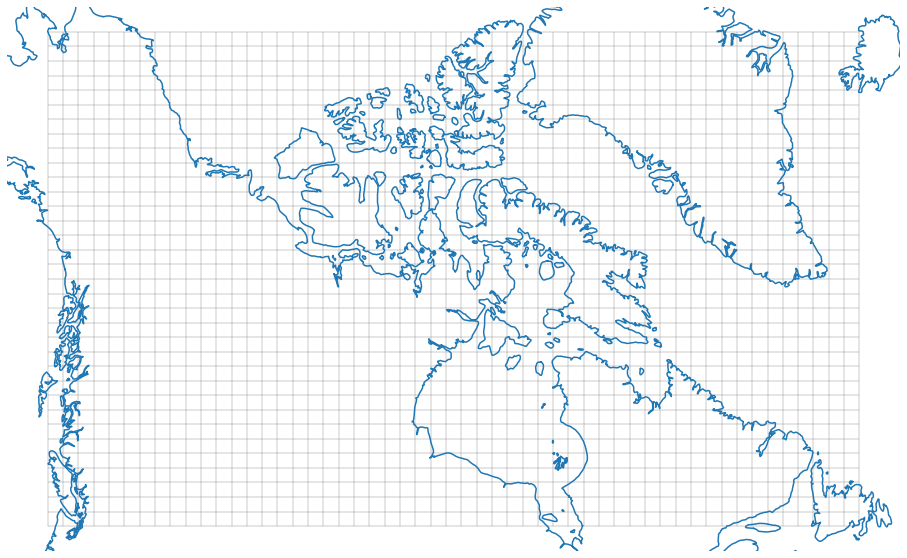

In [2]:
# cubed sphere grid parameters:
position = (-90, 68)  # lon, lat for grid center
orientation = 0       # angle of grid x axis - anti-clockwise from east direction
L, W = 7000e3, 3800e3 # extents [m] of grid
dL, dW = 100e3, 100e3 # spatial resolution [m] of grid 

# create grid object
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, dL, dW, R = 6481.2e3)

# plot grid and coastlines
fig, ax = plt.subplots(figsize = (16, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim);

##### Input data
Next, load datasets. For this example, the files are pre-made and saved in *'./sample_dataset'*. See *Data_handling_with_Lompe* for explanation on how to get the data on this format.

The AMPERE data is downloaded from the AMPERE website, and made into pandas dataframe, stored as HDF with the following code. This reduced file is used to avoid reduce the size of the datafiles on GitHub.

In [ ]:
#import xarray as xr
#import pandas as pd
#import datetime as dt

#ampere = xr.load_dataset('ampere.20120405.k060_m08.north.grd.nc')
#y_ = ampere.year.values[0]
#doy_ = (ampere.doy.values[0]).astype(np.float64)
#t0 = dt.datetime(y_,1,1,0,0) + dt.timedelta(days=(doy_-1))
#times = [t0 + dt.timedelta(hours=i.astype(np.float64)) for i in ampere.time.values]

#data = pd.DataFrame(ampere.jPar, index=times)

#data.to_hdf('20120405_ampere.h5', key='data')

In [3]:
event = '2012-04-05'
# file names and location
supermagfn = './sample_dataset/20120405_supermag.h5'
superdarnfn = './sample_dataset/20120405_superdarn_grdmap.h5' 
iridiumfn = './sample_dataset/20120405_iridium.h5'
amperefn = './sample_dataset/20120405_ampere.h5'

# load data
supermag  = pd.read_hdf(supermagfn)
superdarn = pd.read_hdf(superdarnfn) 
iridium   = pd.read_hdf(iridiumfn)
ampere   = pd.read_hdf(amperefn)

The data must be passed to the lompe Emodel object (created later) as Lompe Data objects. The data that is passed to the Emodel object is the data that will be used in the inversion. However, the data objects above contain data from a whole day (5 April 2012), and we may want to loop over smaller subsets. Here is a function that returns subsets of the data:

In [4]:
def get_data_subsets(t0, t1):
    """ return subsets of data loaded above, between t0 and t1 """
    
    # Iridium data:
    irid = iridium[(iridium.time >= t0) & (iridium.time <= t1)]
    irid_B = np.vstack((irid.B_e.values, irid.B_n.values, irid.B_r.values))
    irid_coords = np.vstack((irid.lon.values, irid.lat.values, irid.r.values))

    # SuperMAG data:
    smag = supermag.loc[t0:t1, :]
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values))
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    # SuperDARN data:
    sd = superdarn.loc[t0:t1, :]
    vlos = sd['vlos'].values
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))

    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    iridium_data   = lompe.Data(irid_B * 1e-9, irid_coords,            datatype = 'space_mag_fac', scale = 200e-9)
    supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag'   , scale = 100e-9)
    superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection'   , scale = 500 )
    
    return(iridium_data, supermag_data, superdarn_data)


##### Set up model and run inversion
Now we have everything we need to set up the Lompe Emodel, add data, and run the inversion for the electric field. If we loop though the whole day, we will plot the output using a function called lompeplot and save the output so that it can be stitched together in a video later. 

For the conductance, we will use the Hardy model with Kp=4, in addition to solar EUV.

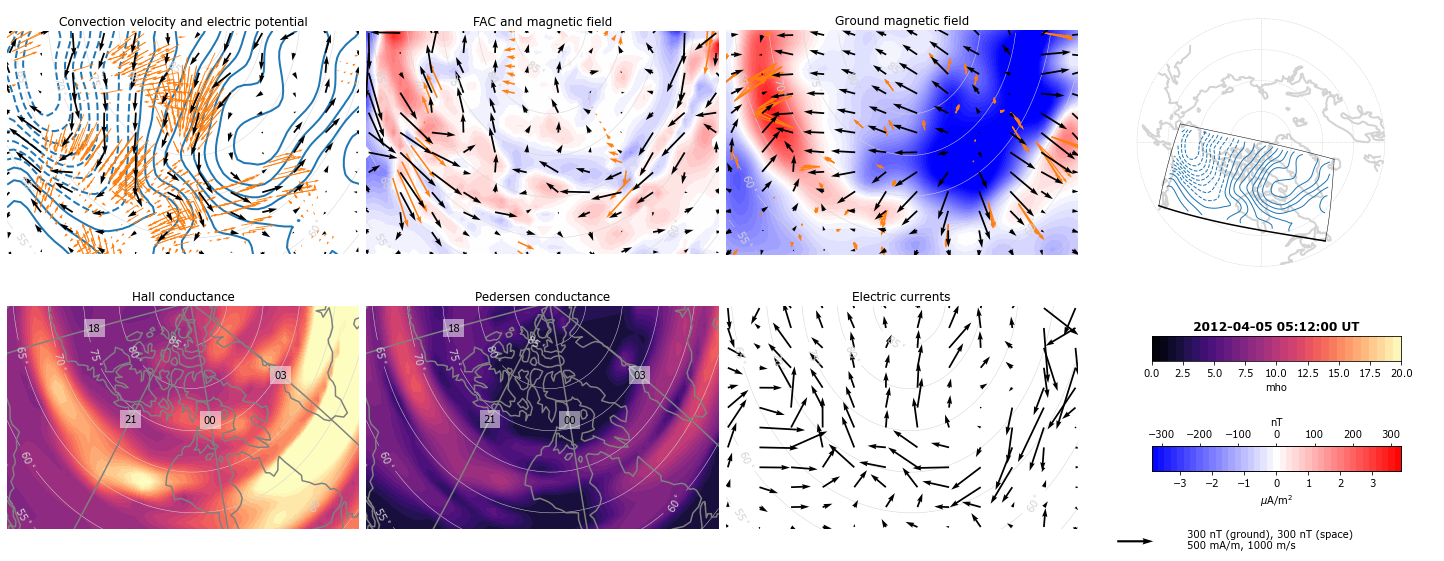

In [7]:
# time to plot for
T0 = dt.datetime(2012, 4, 5, 5, 12)
DT = dt.timedelta(seconds = 60 * 4) # length of time interval

# apex object for plotting in magnetic
apex = apexpy.Apex(T0, refh = 110)

# making conductance tuples
FAC = np.mean(ampere[(ampere.index>=T0) & (ampere.index<T0+DT)].values, axis=0)
sigmaH, sigmaP = lompe.conductance.calculate_robinson_conductance(FAC)
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.robinson_EUV(lon, lat, sigmaH, sigmaP, T0)[0]
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.robinson_EUV(lon, lat, sigmaH, sigmaP, T0)[1]

# Create Emodel object. Pass grid and Hall/Pedersen conductance functions
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add datasets to model
iridium_data, supermag_data, superdarn_data = get_data_subsets(T0 - DT/2, T0 + DT/2) # data from new model time
model.add_data(iridium_data, supermag_data, superdarn_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 1)

# finally, plot (plot is saved as specified path):
fig = lompe.lompeplot(model, include_data = True, time = T0, apex = apex)